For this project, I'm going to look at the correlation between residential property prices and costs for building and construction materials.

https://data.gov.ie/dataset/hpm09-residential-property-price-index   

https://data.gov.ie/dataset/wpm28-wholesale-price-index-excl-vat-for-building-and-construction-materials

I will use CSV files - the reason is that they are the simplest to work with

HPM09.20251124175125.csv - Residential_property_price_index
https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/HPM09/CSV/1.0/en
I've renamed it to - RPPI.csv



WPM28.20251124175238.csv - Wholesale Price Index (Excl VAT) for Building and Construction Materials 
https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/WPM28/CSV/1.0/en
I renamed it to - WPI_BCM.csv


Gathering the Data.
RPPI -
    - It has monthly data from February 2005 to Sept 2025, 
      but to be able to regress against WPI&BCM 
      I will run Sept 2014 to Sept 2014
    - I will remove all the months February 2005 to August 2014 (or not select to import them)

It also has many categories, so i will filter for National - all residential properties
I will be taking index data
I will also ignore all the data talking about the % Change over 12 months for Residential Property Price Index.

WPI-BCM
only goes up to 202409 from 201501
so will probably do Sept 14 to Sept 24

I will filter for the entry of Materials, ignoring the figures for every other category

Cleaning the Data
I will look use the ISNA function to check and replace that i have figures for every entry

Plotting the data, line charts, or indeed regression, 
this should show the posiitve relationship between both sets of data.
Explain, how i could not just pick out any one material because i don't know the proportion that goes into the house, though I could guess.

Investigate - there might be a way of seeing if there is a lagging trend.
Time series data, so need to get the axis working correctly.


In [7]:
# I will want pandas to manipulate my data
import pandas as pd 
# I will want numpy for calculating the descriptive statistics
import numpy as np
# I will want matplotlib to plot my data
import matplotlib.pyplot as plt
# I will want scipy to perform statistical tests
from scipy import stats

# Reading in the Data
We will read in the data in a the form of CSV files from data.gov.ie

In [8]:
# The data is sourced from the Central Statistics Office (CSO) of Ireland
# The dataset is titled "Population by Age Group and Sex"
# The data is available in CSV format via the CSO API
url_rppi = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/HPM09/CSV/1.0/en"
url_wpi_bcm = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/WPM28/CSV/1.0/en"


# read in the data from the csv files into two pandas DataFrames
names_rppi = ["STATISTIC", "Statistic Label", "TLIST(M1)", "Month", "C02803V03373","Type of Residential Property","UNIT", "VALUE"]
df_rppi = pd.read_csv(url_rppi,header=0,usecols=names_rppi)

# We have many rows that we don't need, rows that contain "Percentage Change over 1,3, and 12 months for Residential Property Price Index"
# so let's remove them using regular expressions
df_rppi = df_rppi[df_rppi["Statistic Label"] == "Residential Property Price Index"]
df_rppi = df_rppi[df_rppi["C02803V03373"] == "-"]


number_to_append = "01"
df_rppi["TLIST(M1)"] = df_rppi["TLIST(M1)"].astype("str")
df_rppi["TLIST(M1)"]= df_rppi["TLIST(M1)"]+"01"
df_rppi["TLIST(M1)"] = df_rppi["TLIST(M1)"].astype("datetime64[ns]")

# now that i have many of rows that i don't need removed, I can drop the columns that are no longer necessary
cols_to_drop=  ["STATISTIC", "Month", "Statistic Label", "C02803V03373","Type of Residential Property","UNIT"]
df_rppi = df_rppi.drop(columns=cols_to_drop)

names=["Date","RPPI_Value"]
df_rppi.columns = names

df_rppi.index = pd.DatetimeIndex(df_rppi["Date"])
df_rppi = df_rppi.drop(columns="Date")
#df_wpi_bcm = pd.read_csv(url_wpi_bcm)
df_rppi.info()
# lets take a look at the first few rows of the DataFrame
print(f"{df_rppi.tail()}\n")
#print(f"{df_wpi_bcm.head()}\n")

df_rppi = df_rppi.loc[df_rppi.index > '2014-12-01']
df_rppi = df_rppi.loc[df_rppi.index < '2024-10-01']

df_rppi.to_csv("rppi_data.csv")



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2005-01-01 to 2025-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RPPI_Value  249 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB
            RPPI_Value
Date                  
2025-05-01       194.0
2025-06-01       196.1
2025-07-01       197.7
2025-08-01       199.5
2025-09-01       201.2



In [9]:
url_wpi_bcm = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/WPM28/CSV/1.0/en"

# read in the data from the csv files into two pandas DataFrames
names_wpi_bcm = ["STATISTIC", "Statistic Label", "TLIST(M1)", "Month", "C01409V03262","Type of Material","UNIT", "VALUE"]
df_wpi_bcm = pd.read_csv(url_wpi_bcm,header=0,usecols=names_wpi_bcm)

# We have many rows that we don't need, rows that contain "Percentage Change over 1, 12 month (months) in Wholesale Price Index"
# so let's remove them using regular expressions
df_wpi_bcm = df_wpi_bcm[df_wpi_bcm["Statistic Label"] == "Wholesale Price Index (Excl VAT) for Building and Construction Materials"]
df_wpi_bcm = df_wpi_bcm[df_wpi_bcm["C01409V03262"] == "-"]


number_to_append = "01"
df_wpi_bcm["TLIST(M1)"] = df_wpi_bcm["TLIST(M1)"].astype("str")
df_wpi_bcm["TLIST(M1)"]= df_wpi_bcm["TLIST(M1)"]+"01"
df_wpi_bcm["TLIST(M1)"] = df_wpi_bcm["TLIST(M1)"].astype("datetime64[ns]")

# now that i have many of rows that i don't need removed, I can drop the columns that are no longer necessary
cols_to_drop=  ["STATISTIC", "Month", "Statistic Label", "C01409V03262","Type of Material","UNIT"]
df_wpi_bcm = df_wpi_bcm.drop(columns=cols_to_drop)

names=["Date","WPI_BCM_Value"]
df_wpi_bcm.columns = names

df_wpi_bcm.index = pd.DatetimeIndex(df_wpi_bcm["Date"])
df_wpi_bcm = df_wpi_bcm.drop(columns="Date")
#df_wpi_bcm = pd.read_csv(url_wpi_bcm)
df_wpi_bcm.info()
# lets take a look at the first few rows of the DataFrame
print(f"{df_wpi_bcm.tail()}\n")
#print(f"{df_wpi_bcm.head()}\n")

df_wpi_bcm = df_wpi_bcm.loc[df_wpi_bcm.index > '2014-12-01']
df_wpi_bcm = df_wpi_bcm.loc[df_wpi_bcm.index < '2024-10-01']

df_wpi_bcm.to_csv("wpi_bcm_data.csv")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117 entries, 2015-01-01 to 2024-09-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   WPI_BCM_Value  117 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB
            WPI_BCM_Value
Date                     
2024-05-01          144.3
2024-06-01          144.7
2024-07-01          144.9
2024-08-01          144.6
2024-09-01          144.8



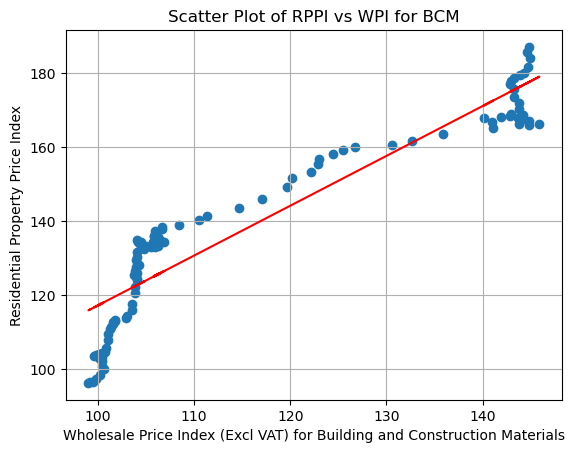

Slope:		 1.3462162700326643
Intercept:	 -17.449959306745882
R-value:	 0.9223637355956088
P-value:	 2.5372149694915646e-49
Standard Error:  0.05257917810073235


In [15]:
combined_df = pd.concat([df_rppi, df_wpi_bcm], axis=1)
# https://pandas.pydata.org/docs/user_guide/merging.html
combined_df.to_csv("combined_rppi_wpi_bcm_data.csv")

x = combined_df["WPI_BCM_Value"]
y = combined_df["RPPI_Value"]    

#https://www.w3schools.com/python/python_ml_linear_regression.asp
slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
    return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel, color='red')
plt.xlabel("Wholesale Price Index (Excl VAT) for Building and Construction Materials")
plt.ylabel("Residential Property Price Index")
plt.title("Scatter Plot of RPPI vs WPI for BCM")
plt.grid(True)
plt.show()

print(f"Slope:\t\t {slope}")
print(f"Intercept:\t {intercept}")
print(f"R-value:\t {r}")
print(f"P-value:\t {p}")
print(f"Standard Error:  {std_err}")


# Add headers - I have no headers
RPPI 
- the first column is just the internal CSO code, add to list of cols to be removed
- second is the index name "Residential Property Price Index", I will change it to RPPI
- third is the year month, I want that column
- fouth is the year month where Month is written alphabetical, maybe want column instead of third
- fifth is the code for the regions don't need, add to list of cols to be removed
- sixth is the region i will filter for all properties i want this
- seventh is base index, i don't need this, add to list of cols to be removed
- eighth is the index, i want this - remember I am starting at row 2299,
- I have another problem, I'm starting at index 95.6 in Sept 2014 because the base is 2015,
but should be fine.



# Cleaning/Simplifying the data
While the data might be clean, there may be a lot of superfluous information in it that we can remove to simplify things.

In [5]:
# The rppi has many categories, I only want the national and all residential properties, so i will filter for this 
# so let's filter the DataFrame to only include rows 
# where the category column is equal to "Ireland"
# We set our dataframe "df" equal that contains a dataframe comprising of data where for every row, 
# the entry for administrative county is Ireland

